In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob

import pandas as pd
import numpy as np
import numpy.ma as ma

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
import geopandas as gpd
from osgeo import gdal


In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'
uzf_dir = gwfm_dir+'/UZF_data/'

In [8]:
end_date = pd.to_datetime('2020-9-30') # end time for analysis
strt_date = pd.to_datetime('2014-10-01')

In [5]:
grid_match = gpd.read_file(join(proj_dir, 'GIS','grid_match.shp'))


In [26]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [24]:
grid_match['id'] = 0
m_domain = grid_match.dissolve('id')

In [28]:
nrow_p, ncol_p = (100, 230)
nrow, ncol = grid_match.row.max(), grid_match.column.max()
delr, delc = (100, 100)

In [6]:
import h5py
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [14]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [17]:
nper_tr = (end_date-strt_date).days+1
# subset data to local model
et_local = np.zeros((nper_tr, nrow, ncol))
et_local[:, grid_match.row-1, grid_match.column-1] = ETc[:,grid_match.p_row-1, grid_match.p_column-1]


In [19]:
uzf_dir = join(gwfm_dir, 'UZF_data')
gde_dir = join(uzf_dir,'shp_GDE_TFT')


In [21]:
GDE_cell = gpd.read_file(join(gde_dir,'Oneto_Denier','GDE_cell.shp'))

In [29]:
lu_native = gpd.read_file(join(uzf_dir, 'county_landuse', 'domain_native_lu_2018.shp'))
lu_native = gpd.overlay(lu_native, m_domain)
# simplify columns
lu_native = lu_native[['name','p_row','p_column','geometry']]

# join polygon to grid and keep cells with more than 0.5 in grid
nat_grid = gpd.overlay(lu_native.to_crs(grid_p.crs), grid_p)
nat_grid = nat_grid[nat_grid.geometry.area > delr*delc*0.5]
# default rooting depth as 4m for native vegetation
nat_grid['rtg_dp'] = 2
# riparian vegation gets deeper roots
nat_grid.loc[nat_grid.name=='Native riparian vegetation', 'rtg_dp'] = 3
nat_grid = nat_grid.drop(columns=['name'])

<Axes: >

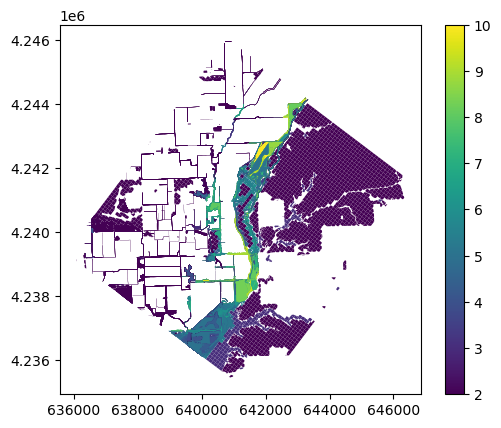

In [30]:
# joining the native land use map to this really helps fill it in 
GDE_all = pd.concat((GDE_cell, nat_grid)).dissolve(['row','column'], aggfunc='mean').reset_index()
GDE_all.plot('rtg_dp', legend=True)

In [31]:
# convert rooting depth to array format for modflow input
# ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = GDE_cell.rtg_dp

# convert rooting depth to array format for modflow input, hydrographs in wells show drawdown to about 10 m
# below ground so should use 10 m for all gde
ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = 10
# ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = 10
ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = GDE_all.rtg_dp

In [32]:
def load_perc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    # years and array index 
    years = pd.date_range(strt_date,end_date,freq='AS-Oct')
    yr_ind = (years-strt_date).days
    perc = np.zeros((nper_tr, nrow_p,ncol_p))
    # need separte hdf5 for each year because total is 300MB
    for n in np.arange(0,len(yr_ind)-1):
    #     arr = pc[yr_ind[n]:yr_ind[n+1]]
        fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
        f = h5py.File(fn, "r")
        arr = f['array']['WY'][:]
        perc[yr_ind[n]:yr_ind[n+1]] = arr
    #     arr_to_h5(arr, fn)
        f.close()
    return(perc)

finf = load_perc(strt_date, end_date)
# ss_finf = load_perc(ss_strt, strt_date)


In [51]:
# subset data to local model
finf_local = np.zeros((nper_tr, nrow, ncol))
finf_local[:, grid_match.row-1, grid_match.column-1] = finf[:,grid_match.p_row-1, grid_match.p_column-1]


In [33]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'CIMIS','Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('zero')['Fair Oaks']
rain = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)

# rain_df = rain_m[ss_strt:strt_date].resample('D').interpolate('zero')['Fair Oaks']
# ss_rain = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


In [49]:
# plt.imshow(ext_dp)
finf.shape

(2192, 100, 230)

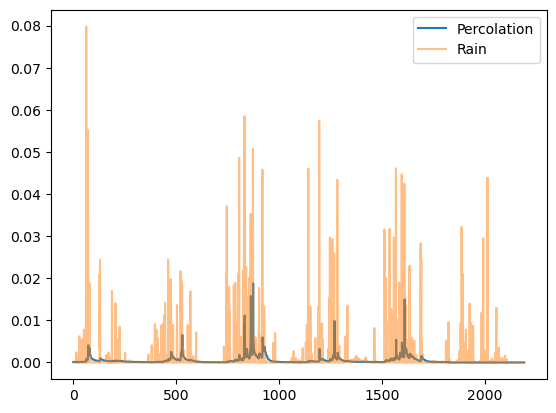

In [54]:
finf_gde = finf_local[:,ext_dp>2].mean(axis=1)
rain_gde = rain[:,ext_dp>2].mean(axis=1)

plt.plot(finf_gde, label='Percolation')
plt.plot(rain_gde, alpha=0.5, label='Rain')
plt.legend()

First few observations are that the soil water budget smooths out the rate of percolation is dependent on the saturation and there is a limiting conductivity that slows down seepage.

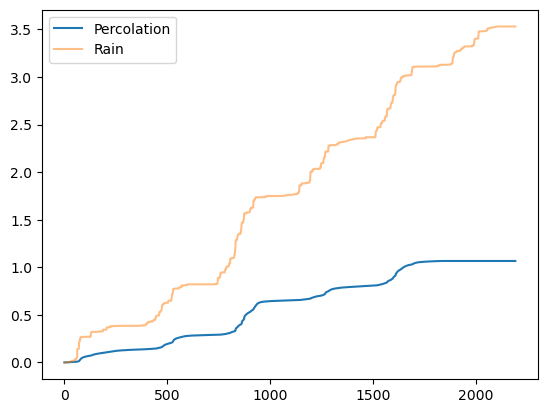

In [55]:
plt.plot(finf_gde.cumsum(), label='Percolation')
plt.plot(rain_gde.cumsum(), alpha=0.5, label='Rain')
plt.legend()

As a designed for in the regional model, the total percolation is about 1/3 of the rainfall.